<a href="https://colab.research.google.com/github/PunitRaveendran/ACM/blob/main/Day-5%20Main%20Challenge%3A%20Dirty%20Dataset%20Detective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-5-1989224335.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-5-1989224335.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

Missing values after imputation:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Missing values after removing the outlier:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


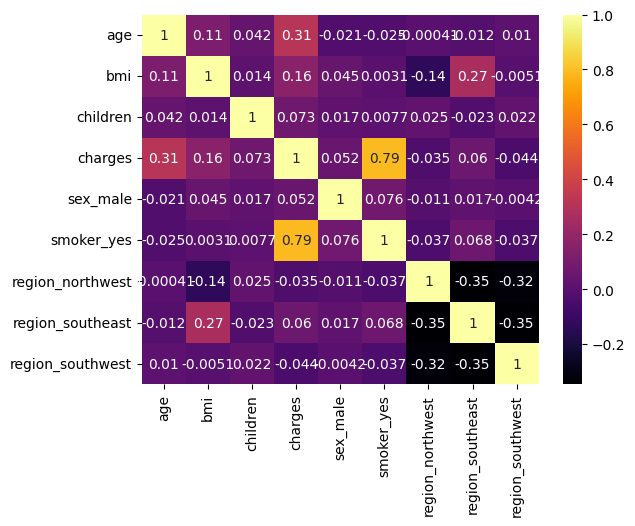

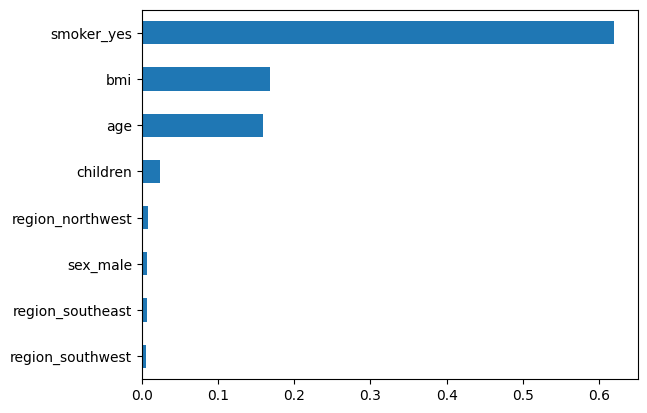

Baseline R²: 0.759363886016615
Improved R²: 0.773177254426846
Best R²: 0.7714123509217311


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

df=pd.read_csv("/content/insurance.csv")

# Standardizing the text
df['sex'] = df['sex'].str.lower().str.strip()
df['smoker'] = df['smoker'].str.lower().str.strip()
df['region'] = df['region'].str.lower().str.strip()

# Replacing common typos
df['sex'] = df['sex'].replace({'malee':'male', 'femle':'female'})

for col in df.select_dtypes(include='object'):
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in df.select_dtypes(exclude='object'):
    df[col].fillna(df[col].median(), inplace=True)

# Check for missing values after imputation
print("Missing values after imputation:")
print(df.isnull().sum())


num_cols = ['age','bmi','children','charges']
for col in num_cols:
    quartile_1 = df[col].quantile(0.25)
    quartile_3 = df[col].quantile(0.75)
    inter_quartile_range = quartile_3 - quartile_1
    lower = quartile_1 - 1.5*inter_quartile_range
    upper = quartile_3 + 1.5*inter_quartile_range
    df[col] = np.clip(df[col], lower, upper)

# Checking for missing values after removing the outliers
print("\nMissing values after removing the outlier:")
print(df.isnull().sum())


# EDA and Feature Selection
# Applying one-hot encoding before calculating correlation heatmap
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

sns.heatmap(df_encoded.corr(), annot=True, cmap='inferno')
plt.show()

X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

rf = RandomForestRegressor(n_estimators=200, random_state=46)
rf.fit(X, y)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

# preprocessing pipeline
numeric_features = ['age','bmi','children']
categorical_features = ['sex','smoker','region']
# This list is kept for reference but not used in the preprocessor applied to X


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough')


# Baseline Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46)
baseline_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)
print("Baseline R²:", r2_score(y_test, y_pred_base))


# Improved Model (XGBoost)
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', XGBRegressor(n_estimators=1500, learning_rate=0.05, max_depth=6, random_state=46))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Improved R²:", r2_score(y_test, y_pred))

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'regressor__n_estimators':[200,500],
    'regressor__max_depth':[5,10]
}
grid = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best R²:", grid.best_score_)